# **Análise dos modelos de linguagem para avaliação das lacunas**

### **Imports**

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy.stats import spearmanr

d:\UFS\GitHub\pln-edu\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Processando as respostas**

In [3]:
DEVICE = 'cpu'

def salvar_cache(cache: dict, caminho_arquivo: str):
    """
    Salva o dicionário de cache em um arquivo usando torch.save.
    """
    try:
        os.makedirs(os.path.dirname(caminho_arquivo), exist_ok=True)
        torch.save(cache, caminho_arquivo)
    except Exception as e:
        print(f"ERRO: Não foi possível salvar o cache. Causa: {e}", file=sys.stderr)

def carregar_cache(caminho_arquivo: str) -> dict:
    """
    Carrega o dicionário de cache de um arquivo usando torch.load.
    Se o arquivo não existir, retorna um dicionário vazio.
    """
    if os.path.exists(caminho_arquivo):
        try:
            cache = torch.load(caminho_arquivo, map_location=DEVICE)
            return cache
        except Exception as e:
            print(f"AVISO: Arquivo de cache encontrado, mas não pôde ser carregado. Causa: {e}", file=sys.stderr)
            print("Iniciando com um cache vazio.", file=sys.stderr)
            return {}
    else:
        return {}

def mapear_correcao_ordinal(row: pd.Series) -> int:
    """Mapeia a coluna 'correcao' para a escala ordinal de 0 a 3"""
    correcao = str(row['correcao']).strip().lower()

    if correcao == 'exata':
        return 3

    if correcao == 'aceitavel':
        return 2
    
    if correcao == 'classe_correta':
        return 1
    
    return 0

def get_embedding(text: str, model_name: str, tokenizer, model) -> torch.Tensor:
    """Obtém o embedding de um texto curto (não contextual)"""
    global EMBEDDING_CACHE 
    
    cache_key = f"{model_name}::{str(text).strip().lower()}"
    if cache_key in EMBEDDING_CACHE:
        return EMBEDDING_CACHE[cache_key]

    try:
        inputs = tokenizer(str(text).strip().lower(), return_tensors='pt', padding=True, truncation=True).to(DEVICE)
        with torch.no_grad():
            output = model(**inputs)
        embedding = F.normalize(output.last_hidden_state[:, 0, :].squeeze(0), p=2, dim=0)
        EMBEDDING_CACHE[cache_key] = embedding 
        return embedding
    except Exception as e:
        print(f"AVISO: Erro ao gerar embedding para '{text}': {e}", file=sys.stderr)
        return torch.zeros(model.config.hidden_size, device=DEVICE)

def get_contextual_embedding(context: str, target: str, model_name: str, tokenizer, model) -> torch.Tensor:
    """Obtém o embedding contextual de uma palavra"""
    global EMBEDDING_CACHE 

    cache_key = f"{model_name}::{context}::{str(target).strip()}"
    if cache_key in EMBEDDING_CACHE:
        return EMBEDDING_CACHE[cache_key]

    if '[LACUNA]' not in context or not str(target).strip():
        return torch.zeros(model.config.hidden_size, device=DEVICE)

    filled_sentence = context.replace('[LACUNA]', str(target).strip(), 1)
    char_start_idx = context.find('[LACUNA]')
    
    inputs = tokenizer(filled_sentence, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    start_token_idx = inputs.char_to_token(char_start_idx)
    end_token_idx = inputs.char_to_token(char_start_idx + len(str(target).strip()) - 1)

    if start_token_idx is None or end_token_idx is None:
        return get_embedding(filled_sentence, model_name, tokenizer, model)

    with torch.no_grad():
        outputs = model(**inputs)
        all_embeddings = outputs.last_hidden_state[0]
    
    word_embeddings = all_embeddings[start_token_idx : end_token_idx + 1]
    contextual_embedding = F.normalize(torch.mean(word_embeddings, dim=0), p=2, dim=0)
    EMBEDDING_CACHE[cache_key] = contextual_embedding 
    return contextual_embedding

def processar_modelos(df: pd.DataFrame, modelos_config: list) -> pd.DataFrame:
    """
    Carrega e processa uma lista de modelos, calculando a similaridade
    com e sem contexto para cada um, usando o método .apply para eficiência.
    """
    for config in modelos_config:
        model_path = config['path']
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path).to(DEVICE).eval()

        col_sem_contexto = f"sim_{config['nome']}_sem_contexto"
        df[col_sem_contexto] = df.apply(
            lambda row: torch.dot(
                get_embedding(row['lacuna'], model_path, tokenizer, model).cpu(),
                get_embedding(row['gabarito'], model_path, tokenizer, model).cpu()
            ).item(),
            axis=1
        )

        col_com_contexto = f"sim_{config['nome']}_com_contexto"
        df[col_com_contexto] = df.apply(
            lambda row: torch.dot(
                get_contextual_embedding(row['contexto'], row['lacuna'], model_path, tokenizer, model).cpu(),
                get_contextual_embedding(row['contexto'], row['gabarito'], model_path, tokenizer, model).cpu()
            ).item(),
            axis=1
        )
    return df

In [ ]:
EMBEDDING_CACHE = carregar_cache('../cache/embeddings_cache.pt')

df = pd.read_csv('../data/processed/[human-eval]dados_teste-cloze.csv')

df['correcao_mapeada'] = df.apply(mapear_correcao_ordinal, axis=1)

modelos = [
    {'nome': 'albertina', 'path': 'PORTULAN/albertina-100m-portuguese-ptbr-encoder'},
    {'nome': 'bertimbau', 'path': 'neuralmind/bert-base-portuguese-cased'}
]

df = processar_modelos(df, modelos)
df.to_csv('../data/processed/[sim-eval]dados_teste-cloze.csv', index=False)

salvar_cache(EMBEDDING_CACHE, '../cache/embeddings_cache.pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## **Análise**

### **Similaridades**

In [5]:
def pre_processamento(df) -> tuple:
    """
    Renomeia colunas para legibilidade e cria as colunas-alvo para as análises.
    """
    df = df.copy()

    mapa_nomes = {
        'sim_albertina_sem_contexto': 'Albertina (Palavra)',
        'sim_albertina_com_contexto': 'Albertina (Contexto)',
        'sim_bertimbau_sem_contexto': 'BERTimbau (Palavra)',
        'sim_bertimbau_com_contexto': 'BERTimbau (Contexto)'
    }
    df.rename(columns=mapa_nomes, inplace=True)
    
    modelos_cols = list(mapa_nomes.values())

    df['correcao_binaria'] = df['correcao_mapeada'].apply(lambda x: 1 if x >= 2 else 0)

    return df, modelos_cols

def analisar_correlacao(df: pd.DataFrame, modelos_cols: list) -> pd.Series:
    """
    Calcula a Correlação de Spearman e gera um gráfico de barras comparativo.
    """
    correlations = {}
    for modelo in modelos_cols:
        corr, _ = spearmanr(df[modelo], df['correcao_mapeada'])
        correlations[modelo] = corr

    corr_series = pd.Series(correlations).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(x=corr_series.index, y=corr_series.values, palette='viridis')
    plt.title('Correlação de Spearman (Pontuação do Modelo vs. Avaliação Humana)', fontsize=16)
    plt.ylabel('Coeficiente de Correlação (ρ)', fontsize=12)
    plt.xlabel('Modelo', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(corr_series.values) * 1.15)

    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.3f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.tight_layout()
    plt.show()
    return corr_series

In [6]:
def analisar_classificacao(df: pd.DataFrame, modelos_cols: list) -> list:
    """
    Calcula e plota as Curvas ROC, e encontra o limiar ótimo para cada modelo.
    """
    y_true = df['correcao_binaria']
    resultados_classificacao = []

    plt.figure(figsize=(8, 6))
    for modelo in modelos_cols:
        y_score = df[modelo]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{modelo} (AUC = {roc_auc:.3f})')

        precision, recall, thresholds = precision_recall_curve(y_true, y_score)

        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)

        best_f1_idx = np.argmax(f1_scores)
        best_f1 = f1_scores[best_f1_idx]
        best_threshold = thresholds[best_f1_idx]
        
        resultados_classificacao.append({
            'modelo': modelo,
            'AUC': roc_auc,
            'F1_score_max': best_f1,
            'limiar_otimo': best_threshold
        })

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
    plt.title('Curva ROC Comparativa dos Modelos', fontsize=16)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True)
    plt.show()
    
    return resultados_classificacao

C:\Users\tulio\AppData\Local\Temp\ipykernel_21800\1471478546.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=corr_series.index, y=corr_series.values, palette='viridis')


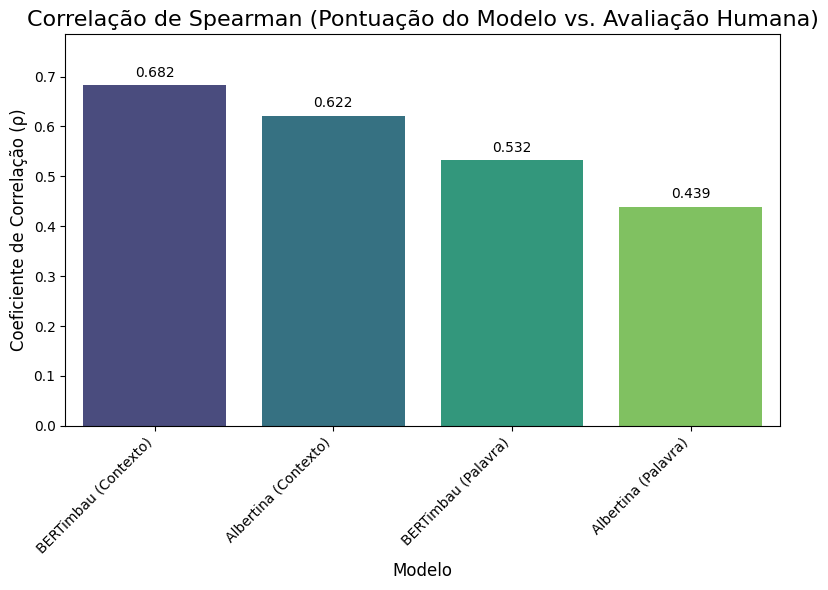

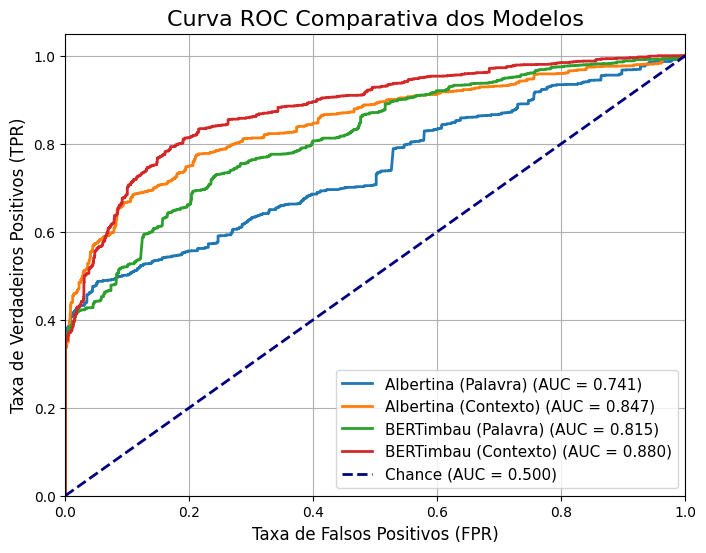

,AUC,F1_score_max,limiar_otimo,spearman_correlation
modelo,,,,
BERTimbau (Contexto),0.879649,0.727489,0.652347,0.682304
Albertina (Contexto),0.847253,0.706205,0.769800,0.621821
BERTimbau (Palavra),0.815037,0.637249,0.876947,0.532290
Albertina (Palavra),0.740922,0.605248,0.992896,0.439486


In [7]:
df_eval = pd.read_csv('../data/processed/[sim-eval]dados_teste-cloze.csv')

df_processado, lista_modelos = pre_processamento(df_eval)

corr_resultados = analisar_correlacao(df_processado, lista_modelos)
class_resultados = analisar_classificacao(df_processado, lista_modelos)

df_class = pd.DataFrame(class_resultados).set_index('modelo')
df_corr = pd.DataFrame(corr_resultados).rename(columns={0: 'spearman_correlation'})

df_relatorio_final = df_class.join(df_corr).sort_values(by='AUC', ascending=False)

display(df_relatorio_final)